In [1916]:
from importlib import reload
import static_model
reload(static_model)
from static_model import *

In [1917]:
import networkx as nx
import numpy as np
import torch

In [1918]:
# import wntr
# import pandas as pd
# import numpy as np

# n_samples = 10
# inp_file = 'network_file.inp'
# Cd = 0.75
# A_max = 0.5

# leak_ratio = np.linspace(0, A_max, n_samples)
# leak_areas = 3.14159 * (leak_ratio / 2) ** 2

# leak_node_id = 'LEAK-0'  # Where to inject the leak

# # Preallocate storage
# pressure_data = []
# flow_data = []

# for area in leak_areas:
#     #wn = base_wn.copy()
#     wn = wntr.network.WaterNetworkModel(inp_file)
#     supply_nodes = wn.reservoir_name_list


#     # Add leak at specified node
#     junction = wn.get_node(leak_node_id)
#     junction.add_leak(wn, area=area, discharge_coeff=Cd, start_time=0)

#     # Run simulation
#     sim = wntr.sim.WNTRSimulator(wn)
#     results = sim.run_sim()

#     # Grab first timestep (static scenario)
#     pressure = results.node['pressure'].iloc[0]  # Series: node_id -> pressure
#     pressure = {k: v for k, v in pressure.items() if k not in supply_nodes}

#     flow = results.link['flowrate'].iloc[0]      # Series: link_id -> flowrate

#     # Append leak area and data
#     pressure_row = {'Leak Area (m²)': area}
#     pressure_row.update(pressure.to_dict())

#     #flow_row = {'Leak Area (m²)': area}
#     #flow_row.update(flow.to_dict())

#     pressure_data.append(pressure_row)
#     #flow_data.append(flow_row)

# # Create final DataFrames
# pressure_df = pd.DataFrame(pressure_data)
# #flow_df = pd.DataFrame(flow_data)

# # Show output
# display(pressure_df)
# #display(flow_df)


In [1919]:
import wntr
import pandas as pd
import numpy as np

n_samples = 10
inp_file = 'network_file.inp'
Cd = 0.75
A_max = 0.5

leak_ratio = np.linspace(0, A_max, n_samples)
leak_areas = 3.14159 * (leak_ratio / 2) ** 2

leak_node_id = 'LEAK-0'  # Where to inject the leak

base_wn = wntr.network.WaterNetworkModel(inp_file)

# Identify supply nodes (e.g., reservoirs)
supply_nodes = base_wn.reservoir_name_list

# Preallocate storage
pressure_data = []

for area in leak_areas:
    wn = wntr.network.WaterNetworkModel(inp_file)

    # Add leak at specified node
    junction = wn.get_node(leak_node_id)
    junction.add_leak(wn, area=area, discharge_coeff=Cd, start_time=0)

    # Run simulation
    sim = wntr.sim.WNTRSimulator(wn)
    results = sim.run_sim()

    # Get pressures at t=0
    pressure = results.link['flowrate'].iloc[0]  # Series: node_id -> pressure

    # Filter out supply nodes
    filtered_pressure = {k: v for k, v in pressure.items() if k not in supply_nodes}

    # Add to results
    pressure_row = {'Leak Area (m²)': area}
    pressure_row.update(filtered_pressure)
    pressure_data.append(pressure_row)

# Create DataFrame
pressure_df = pd.DataFrame(pressure_data)

# Display
display(pressure_df)


,Leak Area (m²),PIPE-0,PIPE-1
0,0.000000,0.050000,0.05
1,0.002424,0.106920,0.05
2,0.009696,0.277236,0.05
3,0.021817,0.558065,0.05
4,0.038785,0.940279,0.05
5,0.060602,1.404327,0.05
6,0.087266,1.918532,0.05
7,0.118779,2.442746,0.05
8,0.155140,2.937326,0.05
9,0.196349,3.372933,0.05


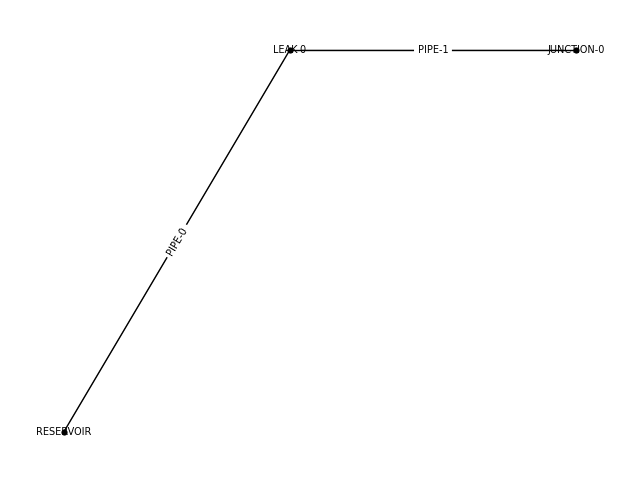

In [1920]:
from wntr.graphics import plot_network
import matplotlib.pyplot as plt

# Plot just the structure of the network
fig, ax = plt.subplots(figsize=(8, 6))
plot_network(wn, node_labels=True, link_labels=True, ax=ax)
plt.show()

In [1921]:
G = wn.to_graph()
reservoirs = list(wn.reservoir_name_list)
# Get all node names (junctions, tanks, reservoirs)
all_nodes = list(G.nodes())

# Filter out reservoirs
non_reservoir_nodes = [n for n in all_nodes if n not in reservoirs]

idx = [i for i, n in enumerate(all_nodes) if n not in reservoirs]

# Get adjacency matrix using filtered nodelist
A  = nx.incidence_matrix(G, oriented=True)
A0 = torch.tensor(A[idx,:].toarray(), dtype=torch.float32)



In [1922]:
import torch

# Suppose you've named your inserted junctions as 'LEAK-0', 'LEAK-1', ..., etc.

num_pipes = len(wn.pipe_name_list) // 2

# Or you could identify them some other way (e.g., tag or custom attribute)
leak_junctions = [f'LEAK-{i}' for i in range(num_pipes)]  # Replace with actual leak names if different

# Map node names to row indices in your reduced incidence matrix A0
node_to_index = {n: i for i, n in enumerate(non_reservoir_nodes)}

# Initialize the mapping matrix: shape [# of non-reservoir nodes, # of leaks]
M = torch.zeros((len(non_reservoir_nodes), len(leak_junctions)))

# Set 1 where the leak area should be applied
for j, leak_junction in enumerate(leak_junctions):
    if leak_junction in node_to_index:
        i = node_to_index[leak_junction]
        M[i, j] = 1.0
    else:
        raise ValueError(f"Leak junction '{leak_junction}' not found in node list.")

In [1923]:
from scipy.sparse import dok_matrix

edgelist = list(G.edges())
supply_nodes = wn.reservoir_name_list  # or include tanks if needed
supply_nodes = list(supply_nodes)  # Ensure it's ordered

# Create edge-to-start-node mapping
edge_start_nodes = [edge[0] for edge in edgelist]

# Create B matrix (|E| x |supply_nodes|), sparse
B = dok_matrix((len(edgelist), len(supply_nodes)), dtype=int)

for i, (start_node) in enumerate(edge_start_nodes):
    if start_node in supply_nodes:
        j = supply_nodes.index(start_node)
        B[i, j] = 1

# Convert to CSR format for efficient arithmetic
B = torch.tensor(B.toarray(), dtype=torch.float32)

In [1924]:
junctions = wn.junction_name_list  # Only junctions have demand

# Get base demands at each junction
D_values = []
for name in junctions:
    junction = wn.get_node(name)
    demand = junction.base_demand  # in m³/s
    D_values.append(demand)

# D is a NumPy array aligned with junction_name_list
D = torch.tensor(D_values, dtype=torch.float32)
print(D)

tensor([0.0000, 0.0500])


In [1925]:
# Get supply node names
supply_nodes = wn.reservoir_name_list  # Or include tanks if needed

# Get heads at each supply node
S_values = []
for name in supply_nodes:
    reservoir = wn.get_node(name)
    head = reservoir.base_head  # This is constant in steady state
    S_values.append(head)

S = torch.tensor(S_values, dtype=torch.float32)
print(S)


tensor([50.])


In [1926]:
pipe_names = wn.pipe_name_list  # List of all pipe IDs

# Get length of each pipe (in meters)
L = torch.tensor([wn.get_link(name).length for name in pipe_names], dtype=torch.float32)

# Get diameter of each pipe (in meters)
d = torch.tensor([wn.get_link(name).diameter for name in pipe_names], dtype=torch.float32)

# Get Hazen-Williams roughness coefficients (unitless)
C = torch.tensor([wn.get_link(name).roughness for name in pipe_names], dtype=torch.float32)

print(C)

tensor([100., 100.])


In [1927]:
torch.linalg.inv(A0.T)

tensor([[0., 1.],
        [1., 1.]])

In [1928]:
model_params = {
    'A0': A0,
    'inv' : torch.linalg.inv(A0.T),
    'M' : M,
    'B' : B,
    'A_max' : leak_areas.max(),
    'S' : S,
    'D' : D,
    'd': d,
    'L': L,
    'Cd' : 0.75, 
    'C' : C,
    'rho' : 1000.0,
    'n_samples' : 10
}

net_params = {
        'layer_sizes' : [200,200,200,A0.shape[0]], 
        'activation' : 'tanh',
}


In [1929]:
print(A0)

tensor([[-1.,  1.],
        [ 1.,  0.]])


In [1930]:
model = Model(model_params, net_params)
model.train(iterations=100000, print_interval=1000)

step       loss       e1          e2
1000       1.82e-03   New Best!
2000       1.42e-03   New Best!
3000       3.09e-04   New Best!
4000       6.83e-05   New Best!
5000       3.30e-05   New Best!
6000       3.63e-04   
7000       1.06e-05   New Best!
8000       4.81e-06   New Best!
9000       2.74e-06   New Best!
10000      2.52e-06   New Best!
11000      8.11e-07   New Best!
12000      8.05e-06   
13000      1.16e-03   
14000      1.06e-03   
15000      1.25e-06   
16000      5.91e-07   New Best!
17000      2.79e-04   
18000      6.07e-07   
19000      1.64e-03   
20000      7.49e-08   New Best!
21000      8.05e-08   
22000      8.32e-08   
23000      1.04e-07   
24000      1.04e-07   
25000      1.05e-07   
26000      4.34e-07   
27000      9.44e-08   
28000      1.60e-05   


KeyboardInterrupt: 

In [ ]:
from IPython.display import display, Markdown
import pandas as pd
import torch

model.eval()

a = torch.linspace(0, leak_areas.max(), 10).reshape(-1, 1)
a = torch.cat((a, torch.zeros_like(a)), dim=-1)                                    

q = model.net(a)

node_names = list(pressure_df.columns[1:])
q = np.flip(q.detach().numpy(), axis=1)
true = pressure_df.drop(columns=['Leak Area (m²)']).to_numpy()

error_np = q - true

print(q)
print(true)

error_df = pd.DataFrame(error_np, columns=node_names)
error_df.insert(0, 'Leak Area (m²)', pressure_df['Leak Area (m²)'].values)

# Display title and table together
display(Markdown("### Pressure Head Prediction Errors at Each Junction (Predicted - True)"))
display(error_df)


Best loss: tensor(7.4936e-08, grad_fn=<MeanBackward0>)
[[0.05  0.05 ]
 [0.558 0.05 ]
 [1.046 0.05 ]
 [1.502 0.049]
 [1.919 0.05 ]
 [2.291 0.05 ]
 [2.62  0.05 ]
 [2.907 0.05 ]
 [3.157 0.05 ]
 [3.373 0.05 ]]
[[0.05  0.05 ]
 [0.107 0.05 ]
 [0.277 0.05 ]
 [0.558 0.05 ]
 [0.94  0.05 ]
 [1.404 0.05 ]
 [1.919 0.05 ]
 [2.443 0.05 ]
 [2.937 0.05 ]
 [3.373 0.05 ]]


### Pressure Head Prediction Errors at Each Junction (Predicted - True)

,Leak Area (m²),PIPE-0,PIPE-1
0,0.000000,-0.000018,-0.000005
1,0.002424,0.451046,-0.000019
2,0.009696,0.769207,0.000240
3,0.021817,0.943492,-0.000661
4,0.038785,0.978281,0.000363
5,0.060602,0.886955,0.000394
6,0.087266,0.701336,-0.000181
7,0.118779,0.464208,-0.000272
8,0.155140,0.219968,-0.000017
9,0.196349,-0.000338,0.000147


(10, 2)


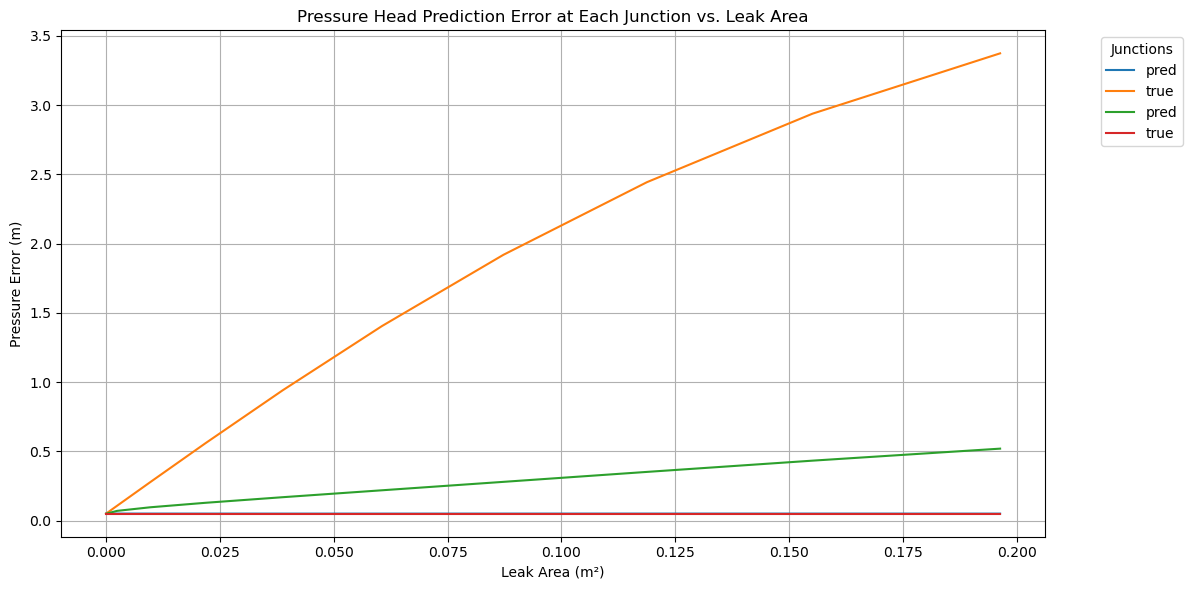

In [1932]:
import matplotlib.pyplot as plt

# --- Assumptions ---
# error_df: DataFrame with columns ['Leak Area (m²)', JUNCTION-0, JUNCTION-1, ...]
# node_names: List of non-supply node names (i.e., columns in error_df, excluding first)

# Extract x and y values
leak_areas = error_df['Leak Area (m²)'].values
node_names = error_df.columns[1:]  # skip 'Leak Area (m²)'

plt.figure(figsize=(12, 6))
print(H_np.shape)

# Plot error at each junction
for i, node in enumerate(node_names):
    plt.plot(leak_areas, H_np[:,i], label='pred')
    plt.plot(leak_areas, true_np[:,i], label='true')

plt.xlabel("Leak Area (m²)")
plt.ylabel("Pressure Error (m)")
plt.title("Pressure Head Prediction Error at Each Junction vs. Leak Area")
plt.legend(title="Junctions", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [1933]:
A = torch.linspace(0, leak_areas.max(), 10).reshape(-1, 1)
H = model.net(A)  # Predicted pressure at JUNCTION-0

A = A.detach()

plt.plot(leak_areas, H.detach().flatten(), label='pred')
plt.plot(leak_areas, pressure_values, label='true')
plt.legend()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x1 and 2x200)

torch.Size([10, 1])


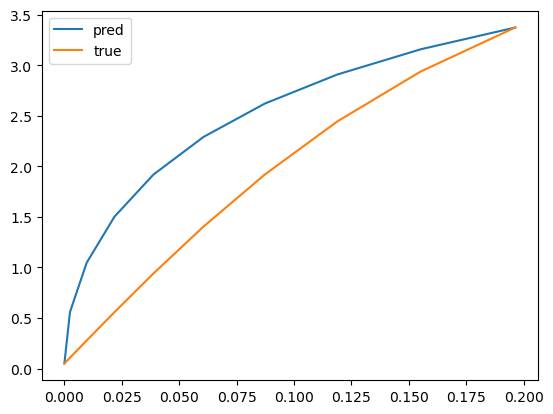

In [ ]:
hL = B @ S - model.mv(A0.T, H)
print(H.shape)


q = torch.sign(hL) * (torch.abs(hL) * C**(1.852) * d**(4.871) / 10.667 / L)**(1 / 1.852)

plt.plot(leak_areas, q.detach().flatten(), label='pred')
plt.plot(leak_areas, flow_values, label='true')
plt.legend()
plt.show()